In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.ndimage import sobel
from skimage import color
from torch.utils.data import Subset

from analysis_utils import *

sys.path.append("../")

from get_mappings import ComputeContributions
from model_all_analysis import HNeRV
from vps_datasets import CityscapesVPSVideoDataSet, VIPSegVideoDataSet

In [ ]:
dataset_names = ["cityscapes", "vipseg"]
vidnames = {
    "cityscapes": ["0005", "0175"],
    "vipseg": ["12_n-ytHkMceew", "26_cblDl5vCZnw"],
}

args_dict = {}
dataloader_dict = {}
weights_dict = {}
models_dict = {}
categories_dicts = {}

for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    args_dict[dataset_name] = {}
    dataloader_dict[dataset_name] = {}
    models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}

    for vidname in vidnames[dataset_name]:
        weights_dict[dataset_name][vidname] = "path/to/checkpoint/"

        args = load_model_args()

        args.weight = os.path.join(
            weights_dict[dataset_name][vidname], f"model_best.pth"
        )
        args.crop_list = "-1" if dataset_name == "cityscapes" else "640_1280"

        model = HNeRV(args)
        model = load_model_checkpoint(model, args)
        models_dict[dataset_name][vidname] = model

        args, categories_dicts[dataset_name][vidname] = load_dataset_specific_args(
            args, dataset_name, vidname
        )

        args_dict[dataset_name][vidname] = args

In [6]:
# Create dataloader
for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:

        args = args_dict[dataset_name][vidname]

        if dataset_name == "cityscapes":
            full_dataset = CityscapesVPSVideoDataSet(args)
        else:
            full_dataset = VIPSegVideoDataSet(args)

        sampler = (
            torch.utils.data.distributed.DistributedSampler(full_dataset)
            if args.distributed
            else None
        )

        args.final_size = full_dataset.final_size
        args.full_data_length = len(full_dataset)
        split_num_list = [int(x) for x in args.data_split.split("_")]
        train_ind_list, args.val_ind_list = data_split(
            list(range(args.full_data_length)), split_num_list, args.shuffle_data, 0
        )

        #  Make sure the testing dataset is fixed for every run
        train_dataset = Subset(full_dataset, train_ind_list)
        train_sampler = (
            torch.utils.data.distributed.DistributedSampler(train_dataset)
            if args.distributed
            else None
        )
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args.batchSize,
            shuffle=False,
            num_workers=args.workers,
            pin_memory=True,
            sampler=train_sampler,
            drop_last=True,
            worker_init_fn=worker_init_fn,
        )

        dataloader_dict[dataset_name][vidname] = train_dataloader

In [7]:
def compute_inference_results(
    dataset_name,
    train_dataloader,
    model,
    args,
    first_frame_only=True,
):

    if dataset_name == "vipseg":
        # Sample few frames
        num_indices = len(train_dataloader) * args.b
        num_samples = 6
        sampled_img_indices = [
            i * (num_indices - 1) // (num_samples - 1) for i in range(num_samples)
        ]

    inference_results = {}
    with torch.no_grad():
        for batch in train_dataloader:
            img_data, norm_idx, img_idx = (
                batch["img"].to("cuda"),
                batch["norm_idx"].to("cuda"),
                batch["idx"].to("cuda"),
            )

            if dataset_name == "vipseg" and (img_idx not in sampled_img_indices):
                continue

            images = batch["img"].cuda()
            _, _, _, decoder_results, img_out = model(norm_idx)

            inference_results[img_idx.item()] = {
                "decoder_results": decoder_results,
                "img_out": img_out,
                "img_gt": images[0],
            }

            if first_frame_only == True:
                break

    return inference_results

In [9]:
# Contribution map vs intensity image
def plot_heatmap_vs_intensity(inference_results, model, args):
    img_idx = 0  # Select the first frame for plotting
    gt_img = inference_results[img_idx]["img_gt"]
    img_out = inference_results[img_idx]["img_out"]
    decoder_results = inference_results[img_idx]["decoder_results"]

    # Get model contributions
    compute_contrib_obj = ComputeContributions(
        model, args, decoder_results, img_out.detach().clone()[0]
    )
    # The following can be extended to include inner blocks of NeRV as well
    head_layer_output_contrib = compute_contrib_obj.compute_head_mappings()
    nerv_blk_3_output_contrib, _ = (
        compute_contrib_obj.compute_last_nerv_block_mappings()
    )

    head_contrib_abs_heatmap = torch.sum(
        torch.abs(head_layer_output_contrib), dim=(0, 1)
    )
    blk_3_contrib_abs_heatmap = torch.sum(
        torch.abs(nerv_blk_3_output_contrib), dim=(0, 1)
    )

    rgb_intensity_image = (gt_img - gt_img.min()) / (gt_img.max() - gt_img.min())
    rgb_intensity_image = rgb_intensity_image.sum(dim=0).cpu()

    fig, axs = plt.subplots(2, 3, figsize=(15, 5), tight_layout=True)

    axs[0][0].imshow(rgb_intensity_image, cmap="magma")
    axs[0][0].set_title("Total RGB Intensity Image")
    axs[0][1].imshow(head_contrib_abs_heatmap.cpu(), cmap="magma")
    axs[0][1].set_title("Head Layer Contribution Heatmap")
    axs[0][2].imshow(blk_3_contrib_abs_heatmap.cpu(), cmap="magma")
    axs[0][2].set_title("NeRV Block 3 Contribution Heatmap")

    normalized_intensity_image = (rgb_intensity_image - rgb_intensity_image.min()) / (
        rgb_intensity_image.max() - rgb_intensity_image.min()
    )
    normalized_head_contrib_heatmap = (
        head_contrib_abs_heatmap - head_contrib_abs_heatmap.min()
    ) / (head_contrib_abs_heatmap.max() - head_contrib_abs_heatmap.min())
    normalized_blk_3_contrib_heatmap = (
        blk_3_contrib_abs_heatmap - blk_3_contrib_abs_heatmap.min()
    ) / (blk_3_contrib_abs_heatmap.max() - blk_3_contrib_abs_heatmap.min())

    head_intensity_contrib_diff = (
        normalized_head_contrib_heatmap - normalized_intensity_image
    )
    blk_3_intensity_contrib_diff = (
        normalized_blk_3_contrib_heatmap - normalized_intensity_image
    )

    gray_image = color.rgb2gray(gt_img.cpu().permute(1, 2, 0))

    # Edges
    sobel_horizontal = sobel(gray_image, axis=0)
    sobel_vertical = sobel(gray_image, axis=1)
    sobel_combined = np.sqrt(sobel_horizontal**2 + sobel_vertical**2)
    axs[1][0].imshow(sobel_combined, cmap="magma")
    axs[1][0].set_title("Edge Map (Sobel Filter)")
    axs[1][1].imshow(head_intensity_contrib_diff.cpu(), cmap="magma")
    axs[1][1].set_title("Diff: Head Heatmap - Intensity Image")
    axs[1][2].imshow(blk_3_intensity_contrib_diff.cpu(), cmap="magma")
    axs[1][2].set_title("Diff: Block 3 Heatmap - Intensity Image")

    for ax in axs.flat:
        ax.axis("off")

    fig.suptitle(f"Frame {img_idx} - Contribution Heatmaps vs Total Intensity Image")

    intensity_vs_heatmap_dict = {
        "rgb_intensity": rgb_intensity_image,
        "heatmaps": {
            "head": head_contrib_abs_heatmap.cpu(),
            "blk_3": blk_3_contrib_abs_heatmap.cpu(),
        },
        "diffs_after_normalize": {
            "head": head_intensity_contrib_diff.cpu(),
            "blk_3": blk_3_intensity_contrib_diff.cpu(),
        },
        "edge_map": sobel_combined,
    }

    return intensity_vs_heatmap_dict

Analyze each video and save the raw values for downstream visualization

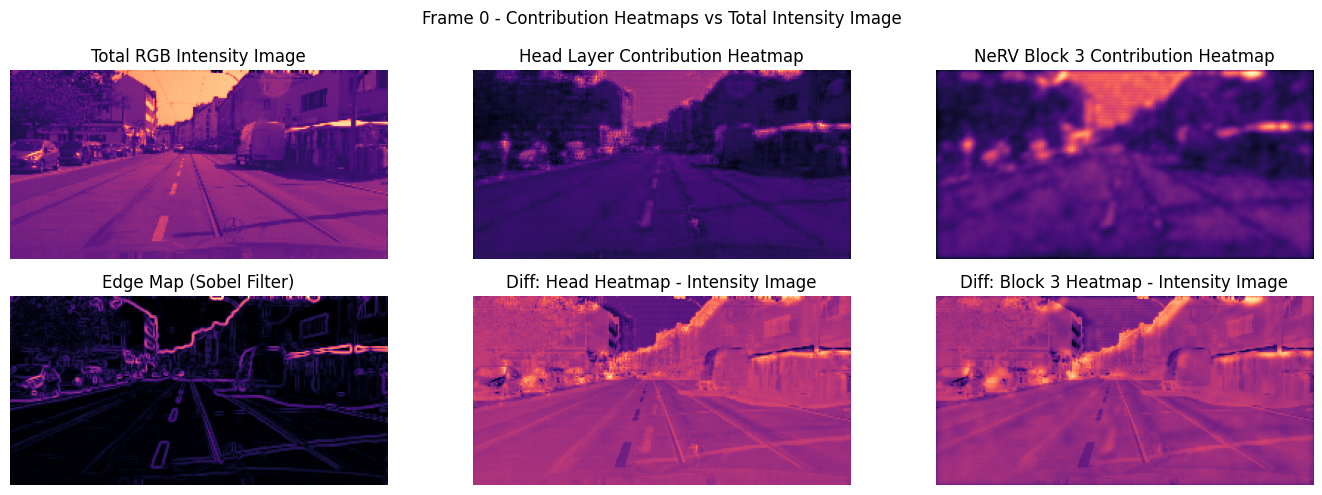

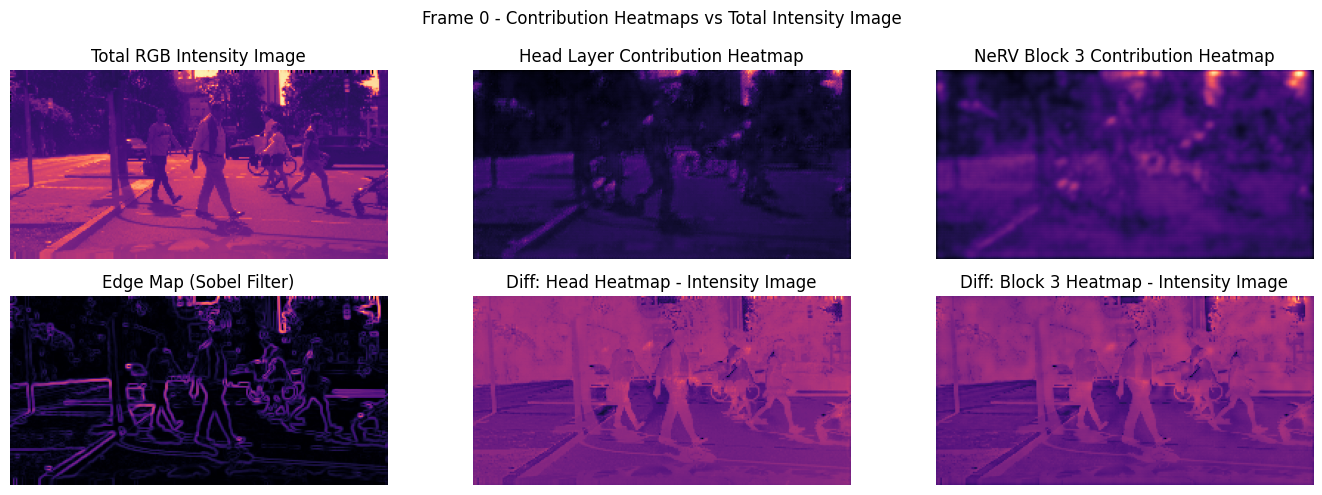

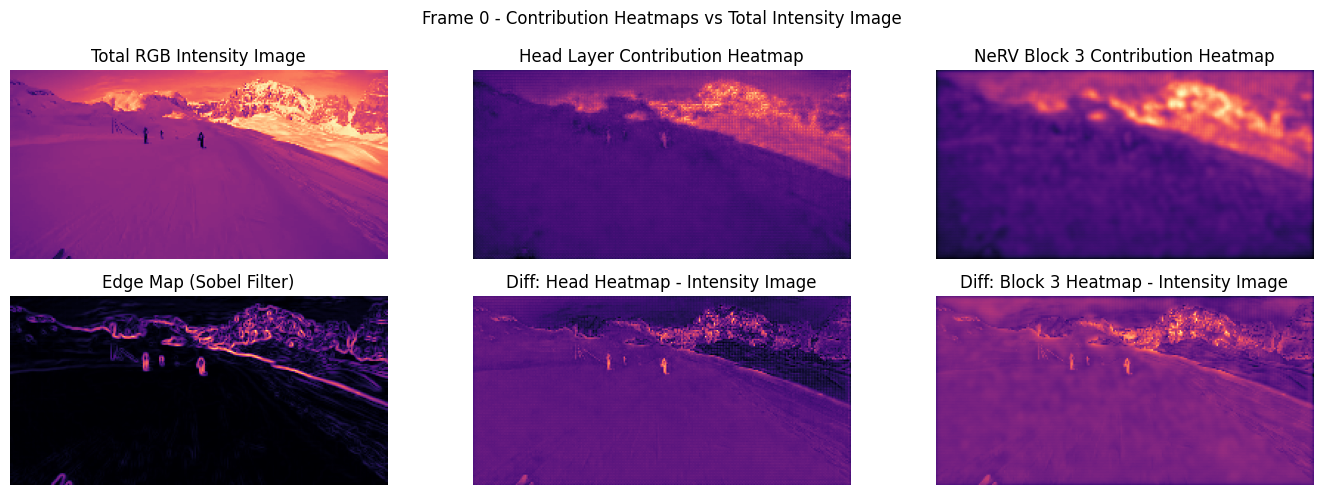

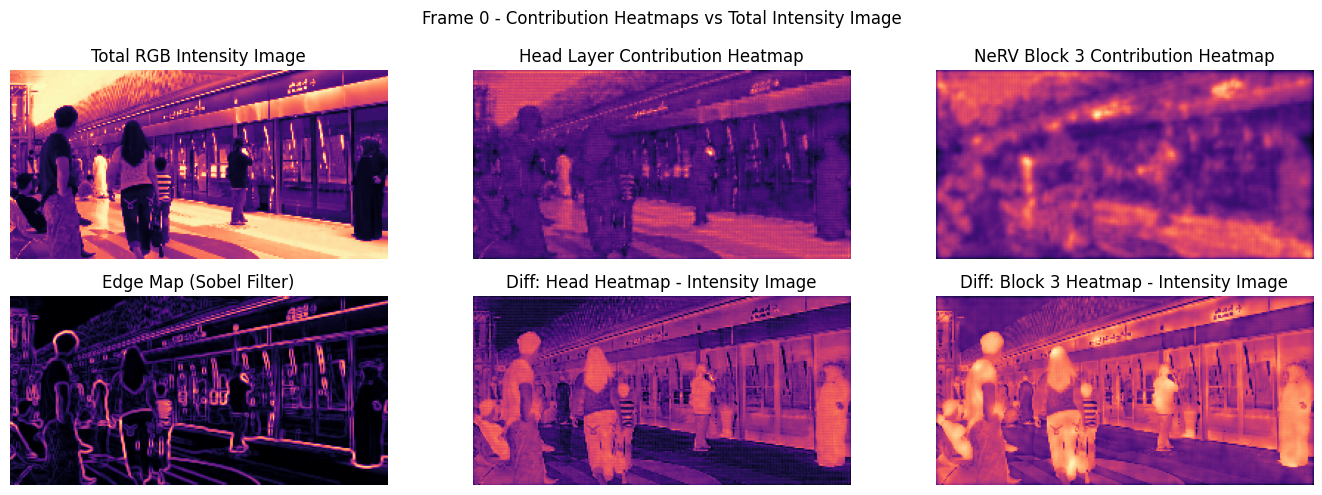

In [11]:
per_vid_intensity_vs_heatmap_dict = {}

for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        train_dataloader = dataloader_dict[dataset_name][vidname]
        model = models_dict[dataset_name][vidname]
        args = args_dict[dataset_name][vidname]

        inference_results = compute_inference_results(
            dataset_name, vidname, train_dataloader, model, args, is_lab=False
        )
        per_vid_intensity_vs_heatmap_dict[vidname] = plot_heatmap_vs_intensity(
            inference_results, model, args
        )

In [12]:
import pickle

save_dir = "../analysis_data/NeRV/contribution_vs_intensity"
os.makedirs(save_dir, exist_ok=True)


with open(os.path.join(save_dir, f"per_vid_intensity_vs_heatmap_dict.pkl"), "wb") as f:
    pickle.dump(per_vid_intensity_vs_heatmap_dict, f)